# StepLRScheduler

In this tutorial we are going to be looking at the `StepLRScheduler` in the `timm` library.

The schedule looks something like:

<img alt="StepLR" src="images/StepLR.png" width="500">

In [1]:
#hide
%load_ext autoreload
%autoreload 2

In [2]:
from timm.scheduler.step_lr import StepLRScheduler
from nbdev.showdoc import show_doc

In [3]:
show_doc(StepLRScheduler)

<h2 id="StepLRScheduler" class="doc_header"><code>class</code> <code>StepLRScheduler</code><a href="https://github.com/rwightman/pytorch-image-models/tree/master/timm/scheduler/step_lr.py#L13" class="source_link" style="float:right">[source]</a></h2>

> <code>StepLRScheduler</code>(**`optimizer`**:`Optimizer`, **`decay_t`**:`float`, **`decay_rate`**:`float`=*`1.0`*, **`warmup_t`**=*`0`*, **`warmup_lr_init`**=*`0`*, **`t_in_epochs`**=*`True`*, **`noise_range_t`**=*`None`*, **`noise_pct`**=*`0.67`*, **`noise_std`**=*`1.0`*, **`noise_seed`**=*`42`*, **`initialize`**=*`True`*) :: `Scheduler`

    

The `StepLRScheduler` as shown above accepts an `optimizer` and also some hyperparams which we will look into in detail below. We will first see how we can train models using the `StepLRScheduler` by first using `timm` training docs and then look at how we can use this scheduler as standalone scheduler for our custom training scripts. 

## Using `StepLRScheduler` scheduler with `timm` training script

To train models using the `StepLRScheduler` we simply update the training script args passed by passing in `--sched step` parameter alongside the necessary hyperparams. In this section we will also look at how each of the hyperparams update the `cosine` scheduler. 

The training command to use `cosine` scheduler looks something like: 

```python 
python train.py ../imagenette2-320/ --sched step
```

## Args

This way we start to use the `StepLRScheduler` with all the defaults. Let's now look at the associated hyperparams and how that updates the annealing schedule. 

### `optimizer`

This is the `optimizer` that will be used for the training process. 

In [4]:
from timm import create_model 
from timm.optim import create_optimizer
from types import SimpleNamespace

In [5]:
model = create_model('resnet34')

args = SimpleNamespace()
args.weight_decay = 0
args.lr = 1e-4
args.opt = 'adam' 
args.momentum = 0.9

optimizer = create_optimizer(args, model)

This `optimizer` object created using `create_optimizer` is what get's passed to the `optimizer` argument. 

### `decay_t`

The number of epochs after which to decay the learning rate where the new learning rate value equals `lr * decay_rate`. 

### `decay_rate`

When `decay_rate` > 0 and <1., at every restart the learning rate is decayed by new learning rate which equals `lr * decay_rate`. So if `decay_rate=0.5`, then in that case, the new learning rate becomes half the initial `lr`. 

In [6]:
from matplotlib import pyplot as plt

def get_lr_per_epoch(scheduler, num_epoch):
    lr_per_epoch = []
    for epoch in range(num_epoch):
        lr_per_epoch.append(scheduler.get_epoch_values(epoch))
    return lr_per_epoch

#### `decay_rate=1.` or no decay

By setting `decay_t` = 5 and `decay_rate` = 1., we are telling the schedule to reduce the learning rate by decay_rate where new lr  `lr * decay_rate` every 5 epochs. 

But since, `decay_rate=1.`, the new learning rate equals the old learning rate hence, we get a constant line. 

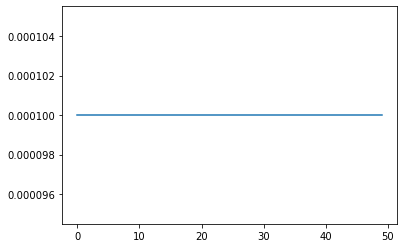

In [7]:
num_epoch = 50
scheduler = StepLRScheduler(optimizer, decay_t = 5, decay_rate=1.)
lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)

plt.plot([i for i in range(num_epoch)], lr_per_epoch);

#### `decay_rate=0.5` 

By setting `decay_t` = 5 and `decay_rate` = 0.5, we are telling the schedule to reduce the learning rate by decay_rate where new lr  `lr * decay_rate` every 5 epochs, that is halve the learning rate after every 5 epochs. 


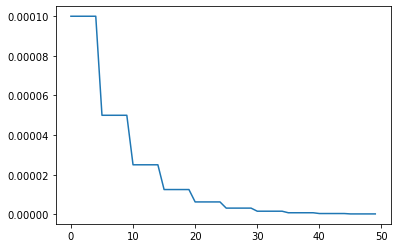

In [8]:
num_epoch = 50
scheduler = StepLRScheduler(optimizer, decay_t = 5, decay_rate=.5)
lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)

plt.plot([i for i in range(num_epoch)], lr_per_epoch);

### `warmup_t` 

Defines the number of warmup epochs. 

### `warmup_lr_init` 

The initial learning rate during warmup. 

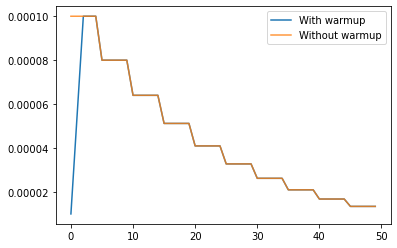

In [9]:
num_epoch = 50
scheduler = StepLRScheduler(optimizer, decay_t=5, warmup_t=2, warmup_lr_init=1e-5, decay_rate=0.8)
lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)
plt.plot([i for i in range(num_epoch)], lr_per_epoch, label="With warmup");

num_epoch = 50
scheduler = StepLRScheduler(optimizer, decay_t=5, decay_rate=0.8)
lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)
plt.plot([i for i in range(num_epoch)], lr_per_epoch, label="Without warmup", alpha=0.8);

plt.legend();

As we can see by setting up `warmup_t` and `warmup_lr_init`, the `cosine` scheduler first starts with a value of `warmup_lr_init`, then gradually progresses up to the `initial_lr` set in the optimizer which is 1e-4. It takes `warmup_t` number of epochs to go from `warmup_lr_init` to `initial_lr`. 

### `noise_range_t`

The upper and lower limit of noise. 

### `noise_pct`

 Percentage of noise to add. 

### `noise_std`

 Noise standard deviation. 

### `noise_seed`

Seed to use to add random noise.

### `t_in_epochs`


If set to False, the learning rates returned for epoch `t` are `None`.

In [10]:
num_epoch = 50
scheduler = StepLRScheduler(optimizer, decay_t=5, t_in_epochs=False)
lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)

lr_per_epoch[:5]

[None, None, None, None, None]

### `initialize`

If True, then inside each param group of the `optimizer` a new field is set called `initial_{field_name}` where `field_name` refers to the field in param group that we are scheduling. Typically `field_name='lr'`.

> NOTE: we leave it up to the reader to try and experiment how the LR annealing scheduling get's updated by adding in noise hyperparams. From here on, this should be a fairly simple exercise. :)